<a href="https://colab.research.google.com/github/alantino-co/Universal-Toroidal-Attractor-in-the-REM-Sleep-EEG/blob/main/Universal_Toroidal_Attractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==================================
#         CELDA 1: INSTALACIÓN
# ==================================
!pip install mne==1.6.0 pyedflib numpy matplotlib scipy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 53.7 MB/s eta 0:00:00


In [2]:
# =========================================================
#    VERSIÓN FINAL CON INDENTACIÓN CORREGIDA
# =========================================================
import mne
import numpy as np
import matplotlib.pyplot as plt
import requests
import os
from scipy.signal import find_peaks
from scipy.optimize import minimize
import pandas as pd
import warnings

# Suprimir advertencias de MNE para una salida más limpia
warnings.filterwarnings('ignore', category=RuntimeWarning)

# --- LISTA DE SUJETOS ---
subjects = ['SC4001', 'SC4002', 'SC4011', 'SC4012', 'SC4021', 'SC4022',
            'SC4031', 'SC4032', 'SC4041', 'SC4042', 'SC4051', 'SC4052',
            'SC4061', 'SC4062', 'SC4071', 'SC4072', 'SC4081', 'SC4082',
            'SC4091', 'SC4092', 'SC4101', 'SC4102', 'SC4111', 'SC4112', 'SC4121', 'SC4131']

all_results = {}
all_spectra = {}

# --- GENERACIÓN DE COMBINACIONES N ---
max_n = 5
n_comb_t3 = [(n1, n2, n3) for n1 in range(max_n+1) for n2 in range(max_n+1) for n3 in range(max_n+1) if not (n1==0 and n2==0 and n3==0)]
n_comb_t2 = [(n1, n2) for n1 in range(max_n+1) for n2 in range(max_n+1) if not (n1==0 and n2==0)]
n_comb_t1 = [(n1,) for n1 in range(1, max_n+1)]

# --- FUNCIONES DE MODELO Y ERROR ---
def model_t3(params, n_combinations):
    f0, A, B, C = np.abs(params)
    return np.sqrt(f0**2 * (A * n_combinations[:,0]**2 + B * n_combinations[:,1]**2 + C * n_combinations[:,2]**2))

def model_t2(params, n_combinations):
    f0, A, B = np.abs(params)
    return np.sqrt(f0**2 * (A * n_combinations[:,0]**2 + B * n_combinations[:,1]**2))

def model_t1(params, n_combinations):
    f0, A = np.abs(params)
    return np.sqrt(f0**2 * (A * n_combinations[:,0]**2))

def error_function(params, observed_freqs, n_combinations, model_func):
    predicted_freqs = model_func(params, n_combinations)
    errors = np.min(np.abs(observed_freqs[:, np.newaxis] - predicted_freqs), axis=1)
    return np.sum(errors**2)

def calculate_aic(n, rss, k):
    if rss <= 1e-9:
        return np.inf
    return n * np.log(rss / n) + 2 * k

# --- FUNCIÓN DE DESCARGA ---
def download_file(url, filename):
    if not os.path.exists(filename):
        print(f"Descargando {filename}...")
        try:
            r = requests.get(url, timeout=60)
            r.raise_for_status()
            with open(filename, 'wb') as f: f.write(r.content)
            return True
        except requests.exceptions.RequestException as e:
            print(f"Fallo en la descarga para {filename}. Error: {e}")
            return False
    return True

# --- BUCLE PRINCIPAL ---
for subject in subjects:
    print(f"\n{'='*20} PROCESANDO SUJETO: {subject} {'='*20}")

    # 1. ADQUISICIÓN DE DATOS
    url_edf = f"https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/{subject}E0-PSG.edf"
    url_hypno = f"https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/{subject}EC-Hypnogram.edf"
    file_edf = f"{subject}E0-PSG.edf"
    file_hypno = f"{subject}EC-Hypnogram.edf"

    if not download_file(url_edf, file_edf) or not download_file(url_hypno, file_hypno):
        print(f"Saltando sujeto {subject} por fallo en la descarga.")
        continue

    # 2. CARGA Y PRE-PROCESAMIENTO
    try:
        raw = mne.io.read_raw_edf(file_edf, preload=True, stim_channel=None)
        annot = mne.read_annotations(file_hypno)
        raw.set_annotations(annot, emit_warning=False)
        raw.pick_channels(['EEG Fpz-Cz'])
        raw.filter(l_freq=0.5, h_freq=45.0, fir_design='firwin', skip_by_annotation='edge')
    except Exception as e:
        print(f"Error procesando archivos para {subject}. Saltando... Error: {e}")
        continue

    # 3. EXTRACCIÓN DE ÉPOCAS REM
    try:
        events, event_id = mne.events_from_annotations(raw, chunk_duration=30.)
        if 'Sleep stage R' not in event_id:
            print(f"No se encontraron datos REM para {subject}. Saltando...")
            continue
        epochs_rem = mne.Epochs(raw, events, event_id=event_id['Sleep stage R'], tmin=0, tmax=30., preload=True, baseline=None)
        if len(epochs_rem) < 10:
            print(f"Datos REM insuficientes para {subject} ({len(epochs_rem)} épocas). Saltando...")
            continue
    except Exception as e:
        print(f"Error extrayendo épocas para {subject}. Saltando... Error: {e}")
        continue

    # 4. ANÁLISIS ESPECTRAL Y DETECCIÓN DE PICOS
    spectrum = epochs_rem.compute_psd(method='welch', n_fft=2048, fmin=0.5, fmax=15.0)
    psds, freqs = spectrum.get_data(return_freqs=True)
    psd_mean = np.mean(psds[:, 0, :], axis=0)

    distance_hz = 0.5
    distance_samples = int(distance_hz / (freqs[1] - freqs[0]))
    peaks, properties = find_peaks(psd_mean, height=np.percentile(psd_mean, 75), distance=distance_samples)

    peak_freqs = freqs[peaks]

    if len(peak_freqs) < 5:
        print(f"No se encontraron suficientes picos ({len(peak_freqs)}) para {subject}. Saltando...")
        continue

    # 5. AJUSTE DE MODELOS Y COMPARACIÓN CON AIC
    n_peaks = len(peak_freqs)

    n_comb_t3_np = np.array(n_comb_t3)
    initial_guess_t3 = [np.min(peak_freqs), 1.0, 1.0, 1.0]
    result_t3 = minimize(error_function, initial_guess_t3, args=(peak_freqs, n_comb_t3_np, model_t3), method='Nelder-Mead')
    rss_t3 = result_t3.fun
    aic_t3 = calculate_aic(n_peaks, rss_t3, k=4)

    n_comb_t2_np = np.array(n_comb_t2)
    initial_guess_t2 = [np.min(peak_freqs), 1.0, 1.0]
    result_t2 = minimize(error_function, initial_guess_t2, args=(peak_freqs, n_comb_t2_np, model_t2), method='Nelder-Mead')
    rss_t2 = result_t2.fun
    aic_t2 = calculate_aic(n_peaks, rss_t2, k=3)

    n_comb_t1_np = np.array(n_comb_t1)
    initial_guess_t1 = [np.min(peak_freqs), 1.0]
    result_t1 = minimize(error_function, initial_guess_t1, args=(peak_freqs, n_comb_t1_np, model_t1), method='Nelder-Mead')
    rss_t1 = result_t1.fun
    aic_t1 = calculate_aic(n_peaks, rss_t1, k=2)

    # 6. ALMACENAR RESULTADOS
    all_results[subject] = {
        'f0': abs(result_t3.x[0]), 'A': abs(result_t3.x[1]), 'B': abs(result_t3.x[2]), 'C': abs(result_t3.x[3]),
        'num_peaks': n_peaks,
        'rss_t3': rss_t3, 'aic_t3': aic_t3,
        'rss_t2': rss_t2, 'aic_t2': aic_t2,
        'rss_t1': rss_t1, 'aic_t1': aic_t1,
    }
    all_spectra[subject] = {'freqs': freqs, 'psd_mean': psd_mean}

    print(f"Sujeto {subject}: {n_peaks} picos encontrados.")
    print(f"  T3 (k=4): RSS={rss_t3:.4f}, AIC={aic_t3:.4f}")
    print(f"  T2 (k=3): RSS={rss_t2:.4f}, AIC={aic_t2:.4f}")
    print(f"  T1 (k=2): RSS={rss_t1:.4f}, AIC={aic_t1:.4f}")

print(f"\n{'='*20} PROCESAMIENTO FINALIZADO {'='*20}")

# 7. SÍNTESIS Y ANÁLISIS DE RESULTADOS
if all_results:
    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    print("\n--- RESUMEN DE LOS VALORES AIC ---")
    print(df_results[['aic_t1', 'aic_t2', 'aic_t3']].round(2))

    best_model_counts = df_results[['aic_t1', 'aic_t2', 'aic_t3']].idxmin(axis=1).value_counts()
    print("\n--- RECUENTO DEL MEJOR MODELO (SEGÚN AIC) ---")
    print(best_model_counts)
else:
    print("\nNo se pudo procesar ningún sujeto con éxito.")


==================== PROCESANDO SUJETO: SC4001 ====================
Descargando SC4001E0-PSG.edf...
Descargando SC4001EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4001E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7949999  =      0.000 ... 79499.990 secs...
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 5.00 Hz (-6 dB cutoff frequency: 47.50 Hz)
- Filter length: 661 samples (6.610 s)



[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
125 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 125 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4001: 7 picos encontrados.
  T3 (k=4): RSS=0.0004, AIC=-60.9186
  T2 (k=3): RSS=0.0699, AIC=-26.2479
  T1 (k=2): RSS=0.8904, AIC=-10.4338

==================== PROCESANDO SUJETO: SC4002 ====================
Descargando SC4002E0-PSG.edf...
Descargando SC4002EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4002E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
NOTE: pick_channels() is a legacy function. New code shou

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
215 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 215 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4002: 5 picos encontrados.
  T3 (k=4): RSS=0.0024, AIC=-30.1992
  T2 (k=3): RSS=0.0006, AIC=-39.5062
  T1 (k=2): RSS=0.1441, AIC=-13.7338

==================== PROCESANDO SUJETO: SC4011 ====================
Descargando SC4011E0-PSG.edf...
Descargando SC4011EC-Hypnogram.edf...
Fallo en la descarga para SC4011EC-Hypnogram.edf. Error: 404 Client Error: Not Found for url: https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4011EC-Hypnogram.edf
Saltando sujeto SC4011 por fallo en la descarga.

=====

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
176 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 176 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4012: 5 picos encontrados.
  T3 (k=4): RSS=0.0003, AIC=-39.9433
  T2 (k=3): RSS=0.0010, AIC=-36.3785
  T1 (k=2): RSS=0.3025, AIC=-10.0248

==================== PROCESANDO SUJETO: SC4021 ====================
Descargando SC4021E0-PSG.edf...
Descargando SC4021EC-Hypnogram.edf...
Fallo en la descarga para SC4021EC-Hypnogram.edf. Error: 404 Client Error: Not Found for url: https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4021EC-Hypnogram.edf
Saltando sujeto SC4021 por fallo en la descarga.

==================== PROCESANDO

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
209 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 209 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4031: 7 picos encontrados.
  T3 (k=4): RSS=0.0006, AIC=-58.1010
  T2 (k=3): RSS=0.0008, AIC=-57.5903
  T1 (k=2): RSS=0.3401, AIC=-17.1714

==================== PROCESANDO SUJETO: SC4032 ====================
Descargando SC4032E0-PSG.edf...
Descargando SC4032EC-Hypnogram.edf...
Fallo en la descarga para SC4032EC-Hypnogram.edf. Error: 404 Client Error: Not Found for url: https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4032EC-Hypnogram.edf
Saltando sujeto SC4032 por fallo en la descarga.

==================== PROCESANDO

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
196 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 196 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4041: 5 picos encontrados.
  T3 (k=4): RSS=0.0052, AIC=-26.3299
  T2 (k=3): RSS=0.0293, AIC=-19.7038
  T1 (k=2): RSS=0.3889, AIC=-8.7693

==================== PROCESANDO SUJETO: SC4042 ====================
Descargando SC4042E0-PSG.edf...
Descargando SC4042EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4042E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8375999  =      0.000 ... 83759.990 secs...
NOTE: pick_channels() is a legacy function. New code shoul

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
270 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 270 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4042: 6 picos encontrados.
  T3 (k=4): RSS=0.0006, AIC=-47.4597
  T2 (k=3): RSS=0.0027, AIC=-40.2053
  T1 (k=2): RSS=0.4047, AIC=-12.1785

==================== PROCESANDO SUJETO: SC4051 ====================
Descargando SC4051E0-PSG.edf...
Descargando SC4051EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4051E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8165999  =      0.000 ... 81659.990 secs...
NOTE: pick_channels() is a lega

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
68 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 68 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4051: 6 picos encontrados.
  T3 (k=4): RSS=0.0002, AIC=-53.1799
  T2 (k=3): RSS=0.0043, AIC=-37.3923
  T1 (k=2): RSS=0.3160, AIC=-13.6622

==================== PROCESANDO SUJETO: SC4052 ====================
Descargando SC4052E0-PSG.edf...
Descargando SC4052EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4052E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8417999  =      0.000 ... 84179.990 secs...
NOTE: pick_channels() is a legacy function. New code should

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 180 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4052: 5 picos encontrados.
  T3 (k=4): RSS=0.0002, AIC=-42.3806
  T2 (k=3): RSS=0.0034, AIC=-30.4237
  T1 (k=2): RSS=0.1488, AIC=-13.5728

==================== PROCESANDO SUJETO: SC4061 ====================
Descargando SC4061E0-PSG.edf...
Descargando SC4061EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4061E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8309999  =      0.000 ... 83099.990 secs...
NOTE: pick_channels() is a lega

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
102 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 102 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4061: 6 picos encontrados.
  T3 (k=4): RSS=0.0001, AIC=-57.6827
  T2 (k=3): RSS=0.0014, AIC=-44.0576
  T1 (k=2): RSS=0.4318, AIC=-11.7893

==================== PROCESANDO SUJETO: SC4062 ====================
Descargando SC4062E0-PSG.edf...
Descargando SC4062EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4062E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8489999  =      0.000 ... 84899.990 secs...
NOTE: pick_channels() is a legacy function. New code shou

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
187 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 187 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4062: 6 picos encontrados.
  T3 (k=4): RSS=0.0006, AIC=-47.6807
  T2 (k=3): RSS=0.0162, AIC=-29.4843
  T1 (k=2): RSS=0.3503, AIC=-13.0451

==================== PROCESANDO SUJETO: SC4071 ====================
Descargando SC4071E0-PSG.edf...
Descargando SC4071EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4071E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8429999  =      0.000 ... 84299.990 secs...
NOTE: pick_channels() is a legacy function. New code shou

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
198 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 198 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4071: 6 picos encontrados.
  T3 (k=4): RSS=0.0003, AIC=-52.0594
  T2 (k=3): RSS=0.0005, AIC=-50.7291
  T1 (k=2): RSS=0.3671, AIC=-12.7628

==================== PROCESANDO SUJETO: SC4072 ====================
Descargando SC4072E0-PSG.edf...
Descargando SC4072EC-Hypnogram.edf...
Fallo en la descarga para SC4072EC-Hypnogram.edf. Error: 404 Client Error: Not Found for url: https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4072EC-Hypnogram.edf
Saltando sujeto SC4072 por fallo en la descarga.

==================== PROCESANDO

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
131 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 131 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4081: 5 picos encontrados.
  T3 (k=4): RSS=0.0018, AIC=-31.7459
  T2 (k=3): RSS=0.0492, AIC=-17.1024
  T1 (k=2): RSS=0.5973, AIC=-6.6240

==================== PROCESANDO SUJETO: SC4082 ====================
Descargando SC4082E0-PSG.edf...
Descargando SC4082EC-Hypnogram.edf...
Fallo en la descarga para SC4082EC-Hypnogram.edf. Error: 404 Client Error: Not Found for url: https://physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4082EC-Hypnogram.edf
Saltando sujeto SC4082 por fallo en la descarga.

==================== PROCESANDO 

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
232 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 232 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4091: 5 picos encontrados.
  T3 (k=4): RSS=0.0000, AIC=-50.0614
  T2 (k=3): RSS=0.0817, AIC=-14.5734
  T1 (k=2): RSS=0.1608, AIC=-13.1854

==================== PROCESANDO SUJETO: SC4092 ====================
Descargando SC4092E0-PSG.edf...
Descargando SC4092EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4092E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...
NOTE: pick_channels() is a lega

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
265 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 265 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4092: 6 picos encontrados.
  T3 (k=4): RSS=0.0006, AIC=-47.3558
  T2 (k=3): RSS=0.0116, AIC=-31.5112
  T1 (k=2): RSS=0.2732, AIC=-14.5350

==================== PROCESANDO SUJETO: SC4101 ====================
Descargando SC4101E0-PSG.edf...
Descargando SC4101EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4101E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8159999  =      0.000 ... 81599.990 secs...
NOTE: pick_channels() is a lega

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
207 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 207 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4101: 5 picos encontrados.
  T3 (k=4): RSS=0.0000, AIC=-50.2627
  T2 (k=3): RSS=0.0022, AIC=-32.6340
  T1 (k=2): RSS=0.0557, AIC=-18.4897

==================== PROCESANDO SUJETO: SC4102 ====================
Descargando SC4102E0-PSG.edf...
Descargando SC4102EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4102E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8573999  =      0.000 ... 85739.990 secs...
NOTE: pick_channels() is a legacy function. New code shou

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
199 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 199 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4102: 5 picos encontrados.
  T3 (k=4): RSS=0.0000, AIC=-53.0574
  T2 (k=3): RSS=0.0006, AIC=-39.1813
  T1 (k=2): RSS=0.3312, AIC=-9.5721

==================== PROCESANDO SUJETO: SC4111 ====================
Descargando SC4111E0-PSG.edf...
Descargando SC4111EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4111E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7925999  =      0.000 ... 79259.990 secs...
NOTE: pick_channels() is a legacy function. New code shoul

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Movement time'), np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
158 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 158 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4111: 6 picos encontrados.
  T3 (k=4): RSS=0.0013, AIC=-42.7560
  T2 (k=3): RSS=0.0086, AIC=-33.2734
  T1 (k=2): RSS=0.1713, AIC=-17.3357

==================== PROCESANDO SUJETO: SC4112 ====================
Descargando SC4112E0-PSG.edf...
Descargando SC4112EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4112E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8339999  =      0.000 ... 83399.990 secs...
NOTE: pick_channels() is a lega

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
151 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 151 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4112: 6 picos encontrados.
  T3 (k=4): RSS=0.0000, AIC=-63.2630
  T2 (k=3): RSS=0.0048, AIC=-36.7448
  T1 (k=2): RSS=0.3281, AIC=-13.4366

==================== PROCESANDO SUJETO: SC4121 ====================
Descargando SC4121E0-PSG.edf...
Descargando SC4121EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4121E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8357999  =      0.000 ... 83579.990 secs...
NOTE: pick_channels() is a legacy function. New code shou

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
258 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 258 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4121: 5 picos encontrados.
  T3 (k=4): RSS=0.0003, AIC=-40.4242
  T2 (k=3): RSS=0.0047, AIC=-28.8405
  T1 (k=2): RSS=0.0851, AIC=-16.3647

==================== PROCESANDO SUJETO: SC4131 ====================
Descargando SC4131E0-PSG.edf...
Descargando SC4131EC-Hypnogram.edf...
Extracting EDF parameters from /content/SC4131E0-PSG.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8441999  =      0.000 ... 84419.990 secs...
NOTE: pick_channels() is a legacy function. New code shou

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.2s finished


Used Annotations descriptions: [np.str_('Sleep stage 1'), np.str_('Sleep stage 2'), np.str_('Sleep stage 3'), np.str_('Sleep stage 4'), np.str_('Sleep stage ?'), np.str_('Sleep stage R'), np.str_('Sleep stage W')]
Not setting metadata
172 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 172 events and 3001 original time points ...
0 bad epochs dropped
Effective window size : 20.480 (s)
Sujeto SC4131: 6 picos encontrados.
  T3 (k=4): RSS=0.0002, AIC=-52.6959
  T2 (k=3): RSS=0.0067, AIC=-34.7452
  T1 (k=2): RSS=0.2223, AIC=-15.7732

==================== PROCESAMIENTO FINALIZADO ====================

--- RESUMEN DE LOS VALORES AIC ---
        aic_t1  aic_t2  aic_t3
SC4001  -10.43  -26.25  -60.92
SC4002  -13.73  -39.51  -30.20
SC4012  -10.02  -36.38  -39.94
SC4031  -17.17  -57.59  -58.10
SC4041   -8.77  -19.70  -26.33
SC4042  -12.18  -40.21  -47.46
SC4051  -13.66  -37.39  -53.18
SC4052  -13.57  -30.42  -42.38
SC4061  -11.79

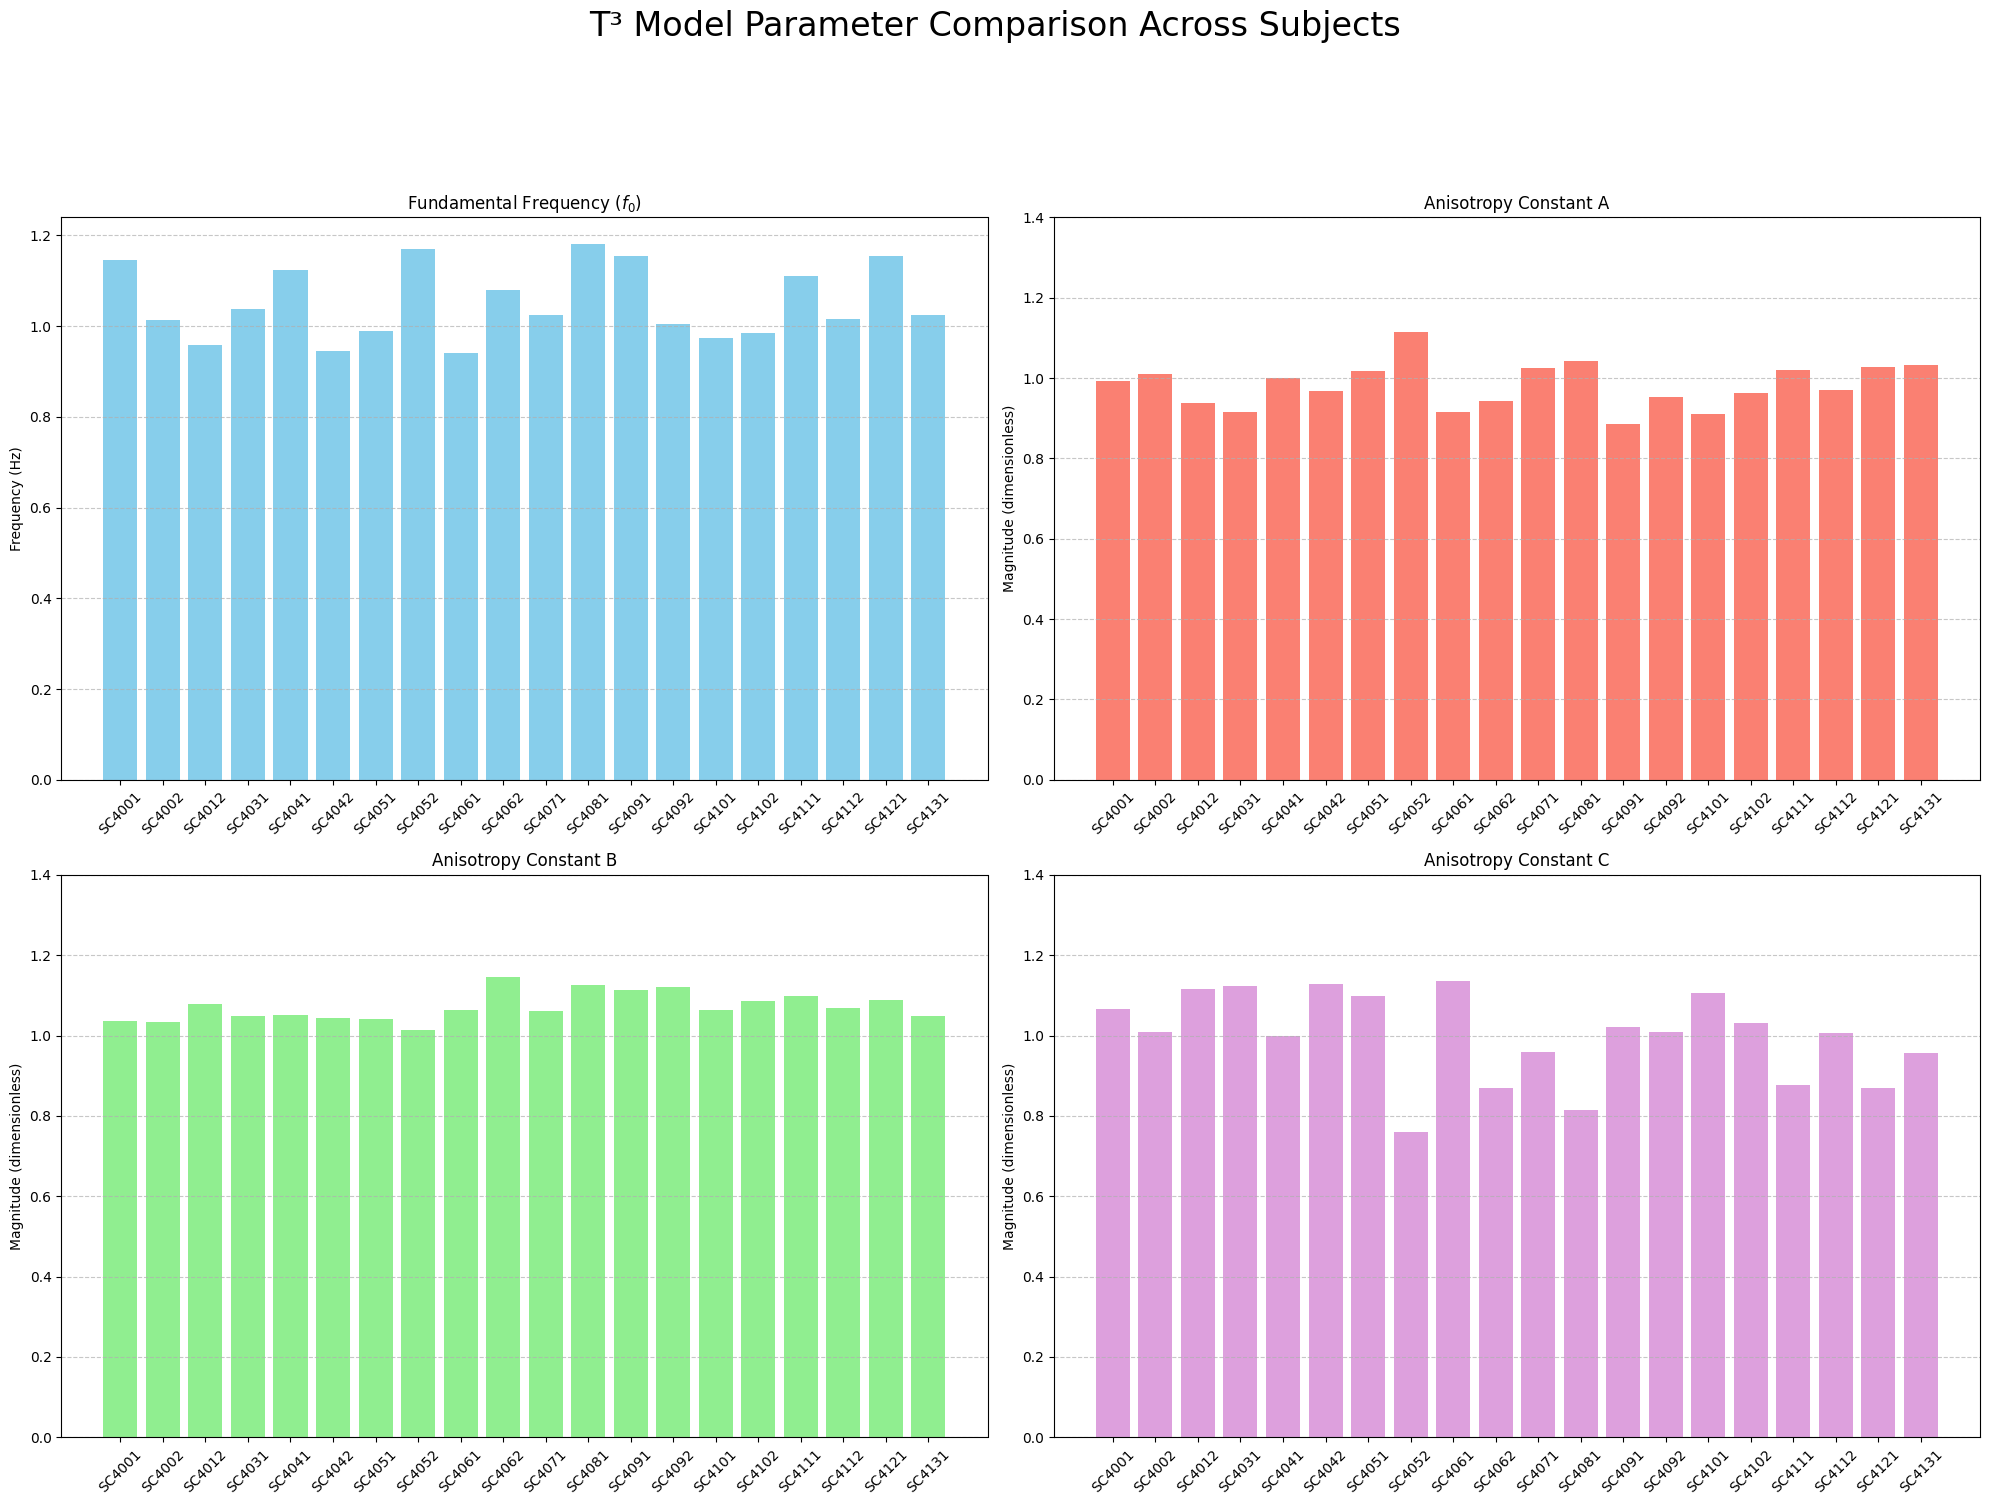

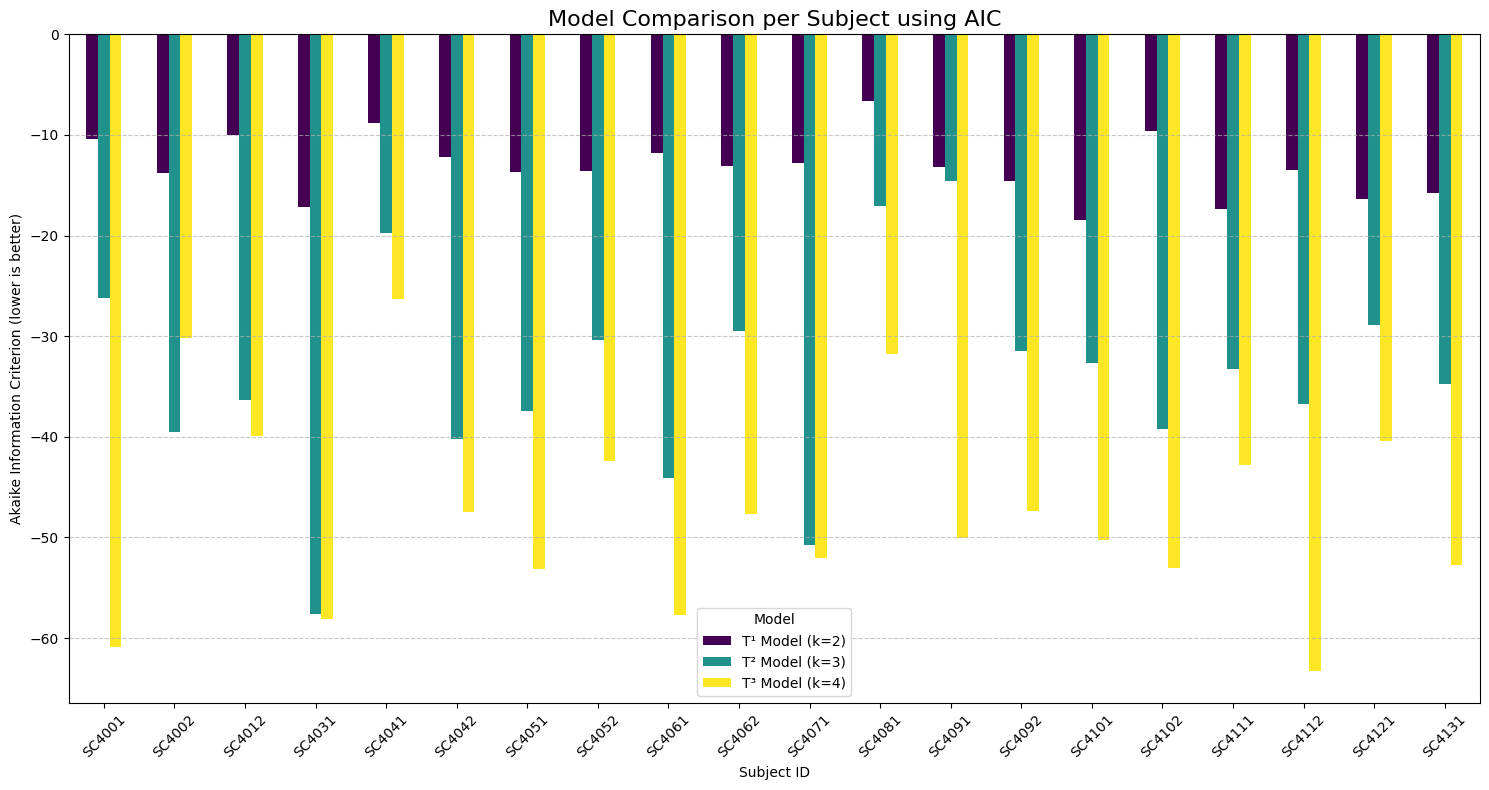

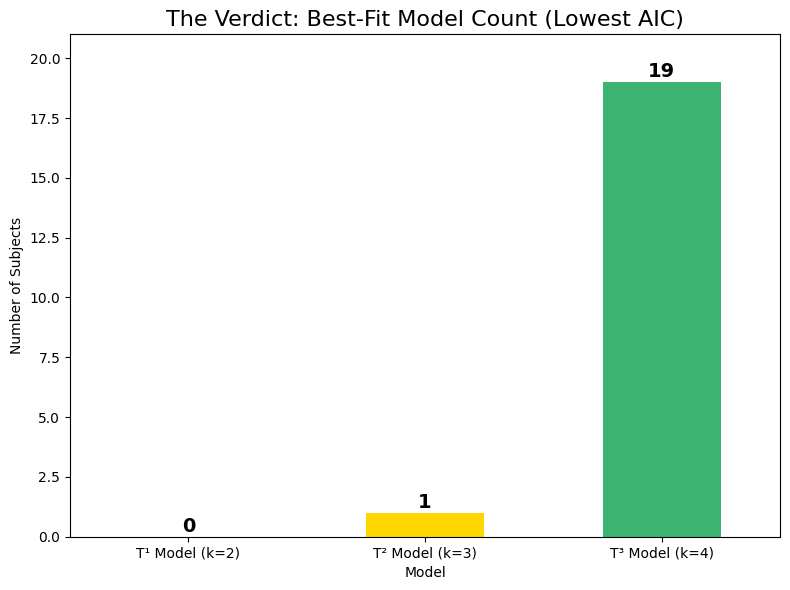

In [3]:
# =================================================================
#    FINAL VISUALIZATION CELL (Corrected, Robust, and in English)
# =================================================================

# Ensure the results DataFrame exists and is not empty
if 'df_results' in locals() and not df_results.empty:

    # --- FIGURE 1 (IMPROVED): T³ Model Parameter Comparison ---


    fig1, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig1.suptitle('T³ Model Parameter Comparison Across Subjects', fontsize=24, y=1.03)

    subjects_list = df_results.index

    axes[0, 0].bar(subjects_list, df_results['f0'], color='skyblue')
    axes[0, 0].set_title('Fundamental Frequency ($f_0$)')
    axes[0, 0].set_ylabel('Frequency (Hz)')

    axes[0, 1].bar(subjects_list, df_results['A'], color='salmon')
    axes[0, 1].set_title('Anisotropy Constant A')
    axes[0, 1].set_ylabel('Magnitude (dimensionless)')
    axes[0, 1].set_ylim(0, 1.4) # Adjusted ylim for better visualization

    axes[1, 0].bar(subjects_list, df_results['B'], color='lightgreen')
    axes[1, 0].set_title('Anisotropy Constant B')
    axes[1, 0].set_ylabel('Magnitude (dimensionless)')
    axes[1, 0].set_ylim(0, 1.4)

    axes[1, 1].bar(subjects_list, df_results['C'], color='plum')
    axes[1, 1].set_title('Anisotropy Constant C')
    axes[1, 1].set_ylabel('Magnitude (dimensionless)')
    axes[1, 1].set_ylim(0, 1.4)

    for ax in axes.flat:
        ax.tick_params(axis='x', rotation=45, labelsize=10)
        ax.grid(axis='y', linestyle='--', alpha=0.7)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("figure_1_parameter_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # --- FIGURE 2 (NEW): AIC Comparison per Subject ---

    df_aic = df_results[['aic_t1', 'aic_t2', 'aic_t3']].copy()
    # Using Unicode superscripts for clarity in the legend
    df_aic.columns = ['T¹ Model (k=2)', 'T² Model (k=3)', 'T³ Model (k=4)']

    fig2, ax2 = plt.subplots(figsize=(15, 8))
    df_aic.plot(kind='bar', ax=ax2, colormap='viridis')

    ax2.set_title('Model Comparison per Subject using AIC', fontsize=16)
    ax2.set_ylabel('Akaike Information Criterion (lower is better)')
    ax2.set_xlabel('Subject ID')
    ax2.tick_params(axis='x', rotation=45)
    ax2.grid(axis='y', linestyle='--', alpha=0.7)
    ax2.legend(title='Model')

    plt.tight_layout()
    plt.savefig("figure_2_aic_comparison.png", dpi=300, bbox_inches='tight')
    plt.show()

    # --- FIGURE 3 (NEW & CORRECTED): Best Model Count Verdict ---

    # Find which model is best for each subject
    best_model_series = df_results[['aic_t1', 'aic_t2', 'aic_t3']].idxmin(axis=1)

    # Count the occurrences
    best_model_counts = best_model_series.value_counts()



    all_models = ['aic_t1', 'aic_t2', 'aic_t3']
    best_model_counts = best_model_counts.reindex(all_models, fill_value=0)



    best_model_counts.index = ['T¹ Model (k=2)', 'T² Model (k=3)', 'T³ Model (k=4)']

    fig3, ax3 = plt.subplots(figsize=(8, 6))
    best_model_counts.plot(kind='bar', ax=ax3, color=['lightcoral', 'gold', 'mediumseagreen'])

    ax3.set_title('The Verdict: Best-Fit Model Count (Lowest AIC)', fontsize=16)
    ax3.set_ylabel('Number of Subjects')
    ax3.set_xlabel('Model')
    ax3.tick_params(axis='x', rotation=0)
    ax3.set_ylim(0, len(df_results) + 1)

    # Add the numbers on top of the bars
    for i, count in enumerate(best_model_counts):
        ax3.text(i, count + 0.2, str(count), ha='center', fontsize=14, weight='bold')

    plt.tight_layout()
    plt.savefig("figure_3_best_model_count.png", dpi=300, bbox_inches='tight')
    plt.show()

else:
    print("The 'df_results' DataFrame was not found. Please run the analysis cell first.")